In [2]:
import torch
import einops

from torch import nn
from torch.nn import functional as F

In [126]:
# E = embed_dim
# N = latent_dim

class S6Block(nn.Module):
    def __init__(self, embed_dim, latent_dim, d, dropout = 0.):
        super().__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim

        self.A_log = nn.Parameter(torch.log(torch.randn(embed_dim, latent_dim)))
        self.BW = nn.Parameter(torch.randn(embed_dim, latent_dim))
        self.CW = nn.Parameter(torch.randn(embed_dim, latent_dim))

        self.DeltaW1 = nn.Parameter(torch.randn(embed_dim, d))
        self.DeltaW2 = nn.Parameter(torch.randn(embed_dim, d))

        self.DeltaBias = nn.Parameter(torch.randn(embed_dim))

        self.WD = nn.Parameter(torch.ones(embed_dim))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)

        batch_size = x.size(0)
        seq_len = x.size(1)

        DeltaW = einops.einsum(self.DeltaW1, self.DeltaW2, 'embed_dim1 d, embed_dim2 d -> embed_dim1 embed_dim2')
        A = -torch.exp(self.A_log) # (embed_dim, latent_dim)

        B = einops.einsum(x, self.BW, 'batch seq embed_dim, embed_dim latent_dim -> batch seq latent_dim')
        C = einops.einsum(x, self.CW, 'batch seq embed_dim, embed_dim latent_dim -> batch seq latent_dim')

        xDeltaW = einops.einsum(x, DeltaW, 'batch seq embed_dim1, embed_dim2 embed_dim1 -> batch seq embed_dim2')
        Delta = F.softplus(xDeltaW + self.DeltaBias) # (batch, seq, embed_dim)

        Delta_repeated = einops.repeat(Delta, 'batch seq embed_dim -> batch seq embed_dim latent_dim', latent_dim = self.latent_dim)

        A_repeated = einops.repeat(A, 'embed_dim latent_dim -> batch seq embed_dim latent_dim', batch = x.size(0), seq = seq_len) # (batch, seq, embed_dim, latent_dim)
        B_repeated = einops.repeat(B, 'batch seq latent_dim -> batch seq embed_dim latent_dim', embed_dim = self.embed_dim) # (batch, seq, embed_dim, latent_dim)

        A_bar = A_repeated * Delta_repeated # (batch, seq, embed_dim, latent_dim)
        B_bar = B_repeated * Delta_repeated # (batch, seq, embed_dim, latent_dim)

        x_by_token = einops.rearrange(x, 'batch seq embed_dim -> seq batch embed_dim')
        A_bar_by_token = einops.rearrange(A_bar, 'batch seq embed_dim latent_dim -> seq batch embed_dim latent_dim')
        B_bar_by_token = einops.rearrange(B_bar, 'batch seq embed_dim latent_dim -> seq batch embed_dim latent_dim')
        C_by_token = einops.rearrange(C, 'batch seq latent_dim -> seq batch latent_dim')

        hs = [torch.zeros(batch_size, self.embed_dim, self.latent_dim, device = x.device)]
        ys = []

        for i in range(seq_len):
            token = x_by_token[i]
            A_bar_t = A_bar_by_token[i]
            B_bar_t = B_bar_by_token[i]
            C_t = C_by_token[i]

            reshaped_token = einops.repeat(token, 'batch embed_dim -> batch embed_dim latent_dim', latent_dim = 1)
            
            # print("Sizes: ", B_bar_t.size(), token.size())
            # print((B_bar_t * reshaped_token).shape)
            h = A_bar_t * hs[-1] + B_bar_t * reshaped_token # (batch, embed_dim, latent_dim)
            y = einops.einsum(C_t, h, 'batch latent_dim, batch embed_dim latent_dim -> batch embed_dim')

            hs.append(h)
            ys.append(y)

        ys = torch.stack(ys, dim = 0) # (seq, batch, embed_dim)
        y = einops.rearrange(ys, 'seq batch embed_dim -> batch seq embed_dim')
        y += x * self.WD # skip connection
        return y

In [133]:
# test the S6Block

testX = torch.randn(2, 3, 4)
print(testX.shape)

block = S6Block(4, 5, 2)
print(block(testX).shape)


torch.Size([2, 3, 4])
torch.Size([2, 3, 4])


In [151]:
class MambaBlock(nn.Module):
    def __init__(self, outer_dim, embed_dim, latent_dim, d, kernel_size, dropout = 0.):
        super().__init__()
        self.project_1 = nn.Linear(outer_dim, embed_dim, bias=False)
        self.project_2 = nn.Linear(outer_dim, embed_dim, bias=False)
        self.project_3 = nn.Linear(embed_dim, outer_dim, bias=False)

        self.s6_block = S6Block(embed_dim, latent_dim, d, dropout = dropout)
        self.conv = nn.Conv1d(embed_dim, embed_dim, bias=True, kernel_size = kernel_size, groups=embed_dim, padding = kernel_size - 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        seq_len = x.size(1)

        # print("Input: ", x.shape)
        # print("Project 1: ", self.project_1(x).shape)
        projx1 = self.project_1(x)
        projx1 = self.dropout(projx1)
        projx2 = self.project_2(x)
        projx2 = self.dropout(projx2)
        activ2 = F.silu(projx2)

        rearranged_proj_x = einops.rearrange(projx1, 'batch seq embed_dim -> batch embed_dim seq')
        convoluted_x = self.conv(rearranged_proj_x) # (batch, embed_dim, seq + 3), plus 3 to account for padding
        convoluted_reshaped = convoluted_x[:, :, :seq_len]
        convoluted_reshaped = einops.rearrange(convoluted_reshaped, 'batch embed_dim seq -> batch seq embed_dim')

        # print("Conv: ", convoluted_reshaped.shape)

        y = self.s6_block(F.silu(convoluted_reshaped))

        prod = projx1 * activ2

        res = self.project_3(self.dropout(y + prod))
        res = self.dropout(res)
        return res + x


In [152]:
# test the MambaBlock

outer_dim = 3

testX = torch.randn(2, 3, outer_dim)
print(testX.shape)

block = MambaBlock(outer_dim, 4, 5, 2, 3)
print(block(testX).shape)

torch.Size([2, 3, 3])
torch.Size([2, 3, 3])


In [153]:
class Mamba(nn.Module):
    def __init__(self, num_layers, outer_dim, embed_dim, latent_dim, d, kernel_size, dropout = 0.):
        super().__init__()
        self.blocks = nn.ModuleList([MambaBlock(outer_dim, embed_dim, latent_dim, d, kernel_size, dropout = dropout) for _ in range(num_layers)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [154]:
# test mamba
params = {
    'num_layers': 2,
    'outer_dim': 6,
    'embed_dim': 10,
    'latent_dim': 5,
    'd': 2,
    'kernel_size': 3,
    'dropout': 0.1
}

testX = torch.randn(2, 3, params['outer_dim'])
print(testX.shape)

mamba = Mamba(**params)
print(mamba(testX))
print(mamba(testX).shape)


torch.Size([2, 3, 6])
tensor([[[-0.6640,  0.8465, -1.1752,  0.4254,  0.4553, -0.3023],
         [ 0.3246,  0.6437,  0.8164,  0.5838,  0.7913,  2.2071],
         [-3.5817, -5.7027, -3.3743, -4.1755,  2.1489, -4.2479]],

        [[-0.9033,  1.3857,  0.7061, -3.4100,  0.3220, -1.4397],
         [-0.8605,  2.1285,  2.0862,  1.6832, -1.5612,  2.0195],
         [ 0.6904, -1.8832, -0.5435, -1.3394, -1.7003, -2.3994]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 3, 6])


In [155]:
# train

import torch.optim as optim
import matplotlib.pyplot as plt


In [156]:
x_train = torch.randn(1000, 100, 6) # (batch, seq_len, outer_dim)
y_train = torch.randn(1000, 1, 6) # (batch, seq_len, outer_dim), seq_len = 1 because we just want to predict the next token


In [157]:
params = {
    'num_layers': 2,
    'outer_dim': 8,
    'embed_dim': 10,
    'latent_dim': 5,
    'd': 2,
    'kernel_size': 3,
    'dropout': 0.0
}

tensor([[[-0.2680,  0.0076, -1.0599, -0.2316,  1.4615,  1.4685]],

        [[-0.6955, -1.1703, -0.2919, -0.9360, -1.2141,  0.3643]],

        [[ 0.3112, -1.2425, -1.5447, -0.0934, -0.3744, -0.4681]],

        [[ 0.8679, -1.5998,  0.9578, -0.4581,  1.2563, -1.3466]],

        [[ 1.1374,  0.4101,  0.5781,  0.2133, -1.2769,  1.4528]],

        [[ 0.6061,  0.4450, -1.1124, -0.8980, -0.8381, -0.1683]],

        [[ 1.6411, -0.0721, -0.0734, -1.1112,  0.2307,  0.2016]],

        [[ 0.0582, -0.7222, -0.0529,  2.6133,  0.9676, -0.0037]],

        [[ 1.0114,  1.1192, -0.3585, -0.1496, -1.3830, -1.7880]],

        [[-1.0803, -2.2784,  0.9551,  0.1211, -0.3160, -2.7753]]],
       grad_fn=<SliceBackward0>)
260.6031894683838
Epoch 0, batch 0: Loss = 2.606031894683838
tensor([[[nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan, nan]],

        [[nan, nan, n

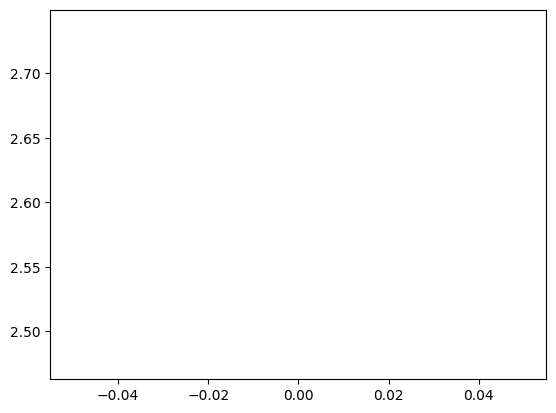

In [158]:
optimizer = optim.Adam(mamba.parameters(), lr = 0.001)

num_epochs = 1
batch_size = 10

running_loss = []
for i in range(num_epochs):
    for j in range(0, x_train.size(1), batch_size):
        x_batch = x_train[j:j + batch_size]
        y_batch = y_train[j:j + batch_size]


        optimizer.zero_grad()
        y_pred = mamba(x_batch)[:,:1]
        print(y_pred)
        loss = F.mse_loss(y_pred, y_batch)
        print(100 * loss.item())
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 100 == 0:
            print(f"Epoch {i}, batch {j}: Loss = {loss.item()}")


plt.plot(running_loss)

print("Done!")